## 1. 数据预处理

In [1]:
import numpy as np
import pandas as pd
import scipy.io
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 数据读取函数定义  
注： mat 文件数据结构见 BatteryDataset 下的 txt 文件

In [2]:
def TimeConvert(hmm):
    """ 
        转换时间格式，将字符串转换成 datatime 格式  
    Args:
        hmm: 待输入的原始时间数据 (ndarray)
    Returns:
        标准化后的时间数据
    """
    year, month, day, hour, minute, second = \
                int(hmm[0]), int(hmm[1]), int(hmm[2]), \
                int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, 
                    hour=hour, minute=minute, second=second)

def LoadMat(mat_file):
    """ 
        加载 mat 文件数据  
    Args:
        mat_file: 待加载的文件路径 (string)
    Returns:
        读取的数据 (list)，其中每个元素为一个嵌套的 dict 类型
    """
    # 函数返回一个字典，其中键是 mat 文件中变量的名称，值是对应的数据数组
    data = scipy.io.loadmat(mat_file)
    # 从文件路径中提取文件名(不包含扩展名),用于访问字典的值
    fileName = mat_file.split('/')[-1].split('.')[0]
    col = data[fileName] # 获取整个数据(一个(1 x N)的四层结构化数组)
    col = col[0][0][0][0] # 去除冗余维度，访问包含所有循环数据的(616,)结构化数组
    size = col.shape[0] # 获取数组的大小(cycle 的数量)
    # print("data['B0005'].dtype:",data['B0005'].dtype,"value:",data['B0005'])
    # print("data['B0005'][0][0][0][0].dtype:",data['B0005'][0][0][0][0].dtype,
    #       "value:",data['B0005'][0][0][0][0])
    # print("data['B0005'][0][0][0][0][0][3][0].dtype:",data['B0005'][0][0][0][0][0][3][0].dtype,
    #       "value:",data['B0005'][0][0][0][0][0][3][0])

    data = []
    for i in range(size): # 遍历每个 cycle 的数据
        """ dtype.fields 方法用于访问 NumPy 结构化数组的字段信息，它返回一个字典，其中：
        键: 是结构化数组中每个字段的名称（字符串）；
        值: 是描述每个字段的元组，包含字段的数据类型、字节偏移量以及可选的标题。 """
        k = list(col[i][3][0].dtype.fields.keys()) # 获取结构化数组(data 字段)中所有子字段名称的列表
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance': # 去除 impedance 类型的数据
            for j in range(len(k)): # 遍历(data 字段)数组中的每个子字段
                t = col[i][3][0][0][j][0] # 获取该字段的数组数据
                l = [t[m] for m in range(len(t))] # 遍历提取数组中每个数据转为列表
                d2[k[j]] = l # 保存该数据及其对应的字段名称(以键值对的形式存在)
        # 将每个样本(cycle)的类型、温度、时间和数据存储到字典 d1 中
        d1['type'], d1['temp'], d1['time'], d1['data'] = \
            str(col[i][0][0]), int(col[i][1][0]), str(TimeConvert(col[i][2][0])), d2
        data.append(d1)

    return data

def GetBatteryCapacity(Battery):
    """ 
        获取单个锂电池的容量数据  
    Args:
        Battery: 单个电池的数据 (dict)
    Returns:
        获取的电池容量数据 (list)，包含两个元素，第一个为放电周期，第二个为容量数据
    """
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge': # 放电状态下获取容量数据
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

def GetBatteryValues(Battery, Type='charge'):
    """ 
        获取单个锂电池充电或放电时的测试数据(默认为充电状态的数据)  
    Args:
        Battery: 单个电池的数据 (dict)
        Type: 指定要读取的数据类型 (string)
    Returns:
        获取的电池数据， list 类型
    """
    data = []
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [3]:
# 用于测试数据
# Battery_list = 'B0005'
# dir_path = r'BatteryDataset/'

# path = dir_path + Battery_list + '.mat'
# data = LoadMat(path)

### 1.2 读取数据

In [4]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = r'BatteryDataset/'

capacity, charge, discharge = {}, {}, {}
for name in Battery_list:
    print('Loading Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = LoadMat(path)
    capacity[name] = GetBatteryCapacity(data) # 放电时的容量数据
    charge[name] = GetBatteryValues(data, 'charge') # 充电数据
    discharge[name] = GetBatteryValues(data, 'discharge') # 放电数据

Loading Dataset B0005.mat ...
Loading Dataset B0006.mat ...
Loading Dataset B0007.mat ...
Loading Dataset B0018.mat ...


### 1.3 数据展示

#### 1.3.1 不同电池容量 vs. 充放电周期曲线

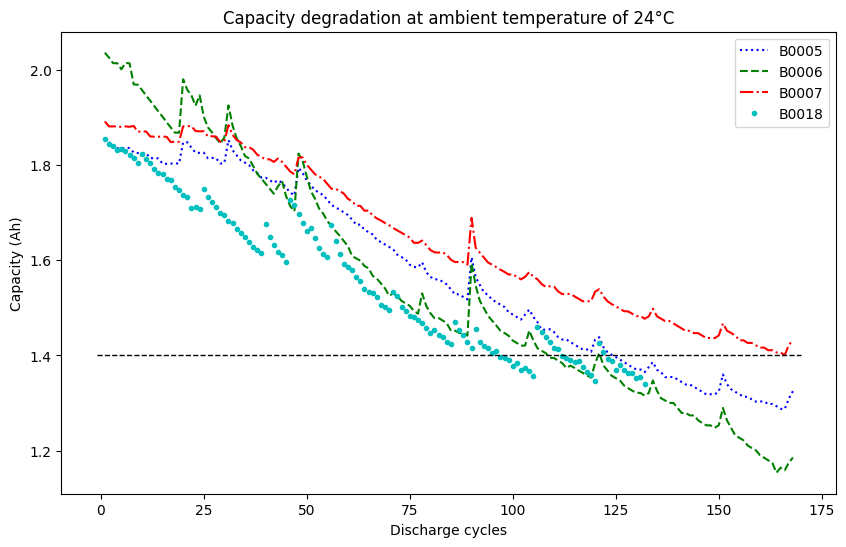

In [5]:
fig, ax = plt.subplots(1, figsize=(10, 6))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = capacity[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
# 临界点直线(电池容量下降30%则认为报废)
plt.plot([-1,170],[2.0*0.7,2.0*0.7],c='black',lw=1,ls='--')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', 
       title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

#### 1.3.2 不同放电周期下，B0005号电池电压 vs. 放电周期曲线

[Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Voltage (V)'),
 Text(0.5, 1.0, 'Voltage vs. Time for Discharge Cycles')]

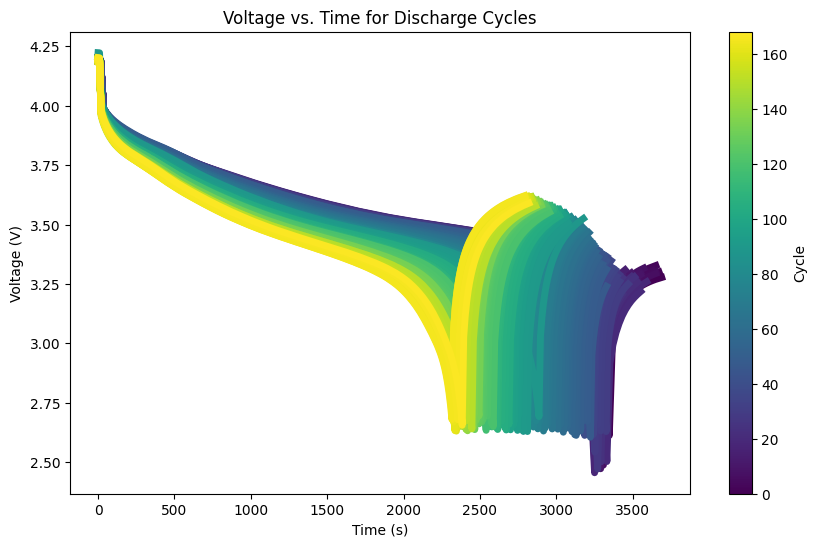

In [6]:
fig, ax = plt.subplots(1, figsize=(10, 6))
cmap = plt.get_cmap('viridis') # 选择合适的颜色映射, 'hsv', 'jet', 'viridis' 等

name = 'B0005' # 仅绘制第 B0005 号电池
for i, cycle_data in enumerate(discharge[name]):
    # 使用 plot 绘制，并根据循环次数着色
    ax.plot(cycle_data['Time'], cycle_data['Voltage_measured'], 
            c=cmap(i / len(discharge[name])), linewidth=5.0)
# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=plt.Normalize(vmin=0, vmax=len(discharge[name])))
sm.set_array([])  # 这是为了让colorbar工作，即使没有明确的映射数组
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cycle') # 添加颜色条标签

ax.set(xlabel='Time (s)', ylabel='Voltage (V)', 
       title='Voltage vs. Time for Discharge Cycles')

#### 1.3.3 不同放电周期下，B0005号电池电流 vs. 充电周期曲线

[Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Current (V)'),
 Text(0.5, 1.0, 'Current vs. Time for discharge Cycles')]

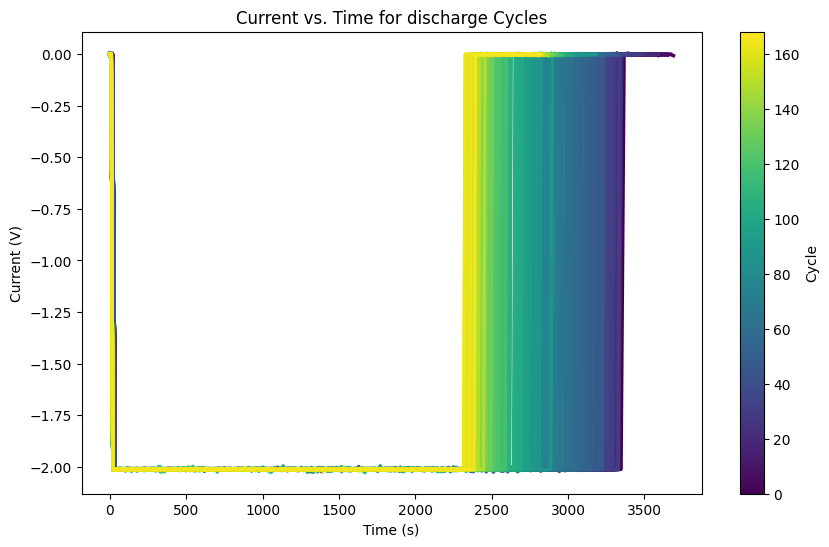

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 6))
cmap = plt.get_cmap('viridis') # 选择合适的颜色映射, 'hsv', 'jet', 'viridis' 等

name = 'B0005' # 仅绘制第 B0005 号电池
for i, cycle_data in enumerate(discharge[name]):
    # 使用 plot 绘制，并根据循环次数着色
    ax.plot(cycle_data['Time'], cycle_data['Current_measured'], 
            c=cmap(i / len(charge[name])), linewidth=2.5)
# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=plt.Normalize(vmin=0, vmax=len(discharge[name])))
sm.set_array([])  # 这是为了让colorbar工作，即使没有明确的映射数组
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cycle') # 添加颜色条标签

ax.set(xlabel='Time (s)', ylabel='Current (V)', 
       title='Current vs. Time for discharge Cycles')

### 1.4 创建数据集

#### 1.4.1 数据集类定义

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from math import sqrt
import random
import os
# 注册设备
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# 定义数据集类
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.window_size = window_size
        self.data = torch.tensor(data, dtype=torch.float32).to(device)
        # 计算最大索引
        self.max_index = self.data.shape[0] - self.window_size - 1

    def __len__(self):
        return self.max_index + 1 #  返回有效数据长度

    def __getitem__(self, index):
        if index > self.max_index:
            raise IndexError(f"Index {index} is out of bounds."
                            f"Max index is {self.max_index}")
        x = self.data[index:index + self.window_size]
        y = self.data[index + self.window_size]
        return x.unsqueeze(1), y.unsqueeze(0) # 添加一个特征维度

#### 1.4.2 数据集获取函数定义

In [10]:
def get_split_dataset(data_dict, name, window_size=8, shuffle=True, 
             capacity_threshold=0.0, train_ratio=0.0, batch_size=32):
    """ 
        获取分割后的训练集和测试集 DataLoader  
    Args:
        data_dict: 字典类型，键为电池名称，值为包含电池信息的元组，
                其中第二个元素是容量数据列表 (list)
        name: 指定为测试集的电池数据名称 (str)  
        window_size: 用于创建时间序列的窗口大小 (int)  
        shuffle: 是否打乱训练集 (bool)  
        train_ratio: 用于训练数据划分的比例 (float32)
        capacity_threshold: 用于训练数据划分的阈值 (float32)
        batch_size: 训练的批大小 (int)  
    Returns:
        包含训练数据和测试数据 DataLoader 的元组。
    """
    data = data_dict[name][1]
    # 创建数据集
    dataset = TimeSeriesDataset(data, window_size)
    # 划分数据集
    if capacity_threshold > 0: # 优先使用阈值前的数据训练，阈值后的数据测试
        max_capacity = max(data)
        capacity = max_capacity * capacity_threshold
        point = next((i for i, val in enumerate(data) if val < capacity), None)
    else: # 否则按照指定的比例进行划分
        if (0 < train_ratio <= 1):
            point = int(len(data) * train_ratio)
        else:
            raise ValueError("Train ratio must be between 0 and 1.")
    # 使用 Subset 创建训练集和验证集，保持时间顺序
    train_dataset = Subset(dataset, range(point))
    test_dataset = Subset(dataset, range(point, len(dataset)))

    # 创建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

def get_data(data_dict, name, window_size=8, shuffle=True, batch_size=32):
    """ 
        留一法获取训练集和测试集 DataLoader,每次留一个电池的数据作为测试集  
    Args:  
        data_dict: 字典类型，键为电池名称，值为包含电池信息的元组，
                其中第二个元素是容量数据列表 (list)  
        name: 指定为测试集的电池数据名称 (str)  
        window_size: 用于创建时间序列的窗口大小 (int)  
        shuffle: 是否打乱训练集 (bool)  
        batch_size: 训练的批大小 (int)  
    Returns:
        包含训练数据和测试数据 DataLoader 的元组。
    """
    test_data = data_dict[name][1]
    test_dataset = TimeSeriesDataset(test_data, window_size)

    train_datasets = []
    for k, v in data_dict.items():
        if k != name:
            dataset = TimeSeriesDataset(v[1], window_size)
            train_datasets.append(dataset)
    train_dataset = ConcatDataset(train_datasets) # 使用 ConcatDataset 拼接多个数据集

    # 创建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 打印 DataLoader
    # print("train_loader_num:", len(train_loader.dataset))
    # print("test_loader_num:", len(test_loader.dataset))
    # for x, y in train_loader:
    #     print("x:", x.shape) # 输出: x: (batch_size, window_size, num_features)
    #     print("y:", y.shape) # 输出: y: (batch_size, 1)
    #     break
    return train_loader, test_loader


In [11]:
# window_size = 8
# for i in range(len(Battery_list)):
#     name = Battery_list[i]
#     get_data(capacity, name, window_size)

## 2. 模型建立

In [12]:
# 定义CNN层
class CNNLayer(nn.Module):
    def __init__(self, num_channels, out_dim, kernel_size=1):
        super(CNNLayer, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_channels, 
                               out_channels=out_dim, 
                               kernel_size=kernel_size)
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) # x.shape([batch_size, out_dim, 1])
        return x

# 定义LSTM层
class LSTMLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, bidirectional):
        super(LSTMLayer, self).__init__()
        self.hidden_size = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, batch_first=True, 
                            bidirectional=bidirectional)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2 if self.bidirectional else 
                         self.num_layers, x.size(0), 
                         self.hidden_size).to(device) # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers*2 if self.bidirectional else 
                         self.num_layers, x.size(0), 
                         self.hidden_size).to(device)  # 初始化记忆状态c0
        output, (hidden, cell) = self.lstm(x, (h0, c0))
        # output.shape([batch_size, 1, hidden_dim*2 if bidirectional else hidden_dim])
        return output

# 定义Attention层
class AttentionLayer(nn.Module):
    def __init__(self, feature_dim, step_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(feature_dim, step_dim)
        self.context_vector = nn.Linear(step_dim, 1, bias=False)

    def forward(self, x):
        # 将输出值限制在 -1 到 1 之间，shape：[batch_size, feature_dim, step_dim]
        attention_weights = torch.tanh(self.attention(x))
        # 为每个时间步计算一个未归一化的注意力权重，shape：[batch_size, 1]
        attention_weights = self.context_vector(attention_weights).squeeze(2)
        attention_weights = F.softmax(attention_weights, dim=1) # 对权重归一化
        # 将注意力权重与输入 x 相乘，shape：[batch_size, feature_dim]
        context_vector = torch.bmm(attention_weights.unsqueeze(1), x).squeeze(1)
        return context_vector, attention_weights

# 建立组合模型 CNN-LSTM-Attention
class CLAM(nn.Module):
    def __init__(self, num_channels, out_dim, kernel_size, hidden_dim,
                  num_layers, bidirectional, step_dim, output_dim):
        super(CLAM, self).__init__()
        self.cnn = CNNLayer(num_channels, out_dim, kernel_size)
        self.lstm = LSTMLayer(out_dim, hidden_dim, 
                              num_layers, bidirectional)
        self.attention = AttentionLayer(hidden_dim * 2 if bidirectional else 
                                        hidden_dim, step_dim)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    
    def forward(self, x):
        x = x.transpose(1, 2) # 交换维度
        x = self.cnn(x)
        x = x.transpose(1, 2)
        x = self.lstm(x)
        x, _ = self.attention(x)
        x = self.fc(x)
        # x = self.fc(x[:, -1, :]) # 取序列最后一个时间步的输出作为预测
        return x
    
    # 建立组合模型 CNN-LSTM
class CLM(nn.Module):
    def __init__(self, num_channels, out_dim, kernel_size, hidden_dim, 
                 num_layers, bidirectional, output_dim):
        super(CLM, self).__init__()
        self.cnn = CNNLayer(num_channels, out_dim, kernel_size)
        self.lstm = LSTMLayer(out_dim, hidden_dim, 
                              num_layers, bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    
    def forward(self, x):
        x = x.transpose(1, 2) # 交换维度
        x = self.cnn(x)
        x = x.transpose(1, 2)
        x = self.lstm(x)
        # x = self.fc(x)
        x = self.fc(x[:, -1, :]) # 取序列最后一个时间步的输出作为预测
        return x

# 建立组合模型 LSTM-Attention
class LAM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, 
                 bidirectional, step_dim, output_dim):
        super(LAM, self).__init__()
        self.lstm = LSTMLayer(input_dim, hidden_dim, 
                              num_layers, bidirectional)
        self.attention = AttentionLayer(hidden_dim * 2 if bidirectional else 
                                        hidden_dim, step_dim)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.lstm(x)
        x, _ = self.attention(x)
        x = self.fc(x)
        # x = self.fc(x[:, -1, :]) # 取序列最后一个时间步的输出作为预测
        return x

    # 建立模型 LSTM
class LM(nn.Module):
    def __init__(self, input_dim, hidden_dim, 
                 num_layers, bidirectional, output_dim):
        super(LM, self).__init__()
        self.lstm = LSTMLayer(input_dim, hidden_dim, 
                              num_layers, bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.lstm(x)
        # x = self.fc(x)
        x = self.fc(x[:, -1, :]) # 取序列最后一个时间步的输出作为预测
        return x

## 3. 模型训练

### 3.1 训练函数定义

#### 3.1.1 模型获取函数和批训练函数定义

In [13]:
def get_model(num_channels, out_dim, kernel_size, feature_dim, hidden_dim, num_layers, 
              bidirectional, step_dim, output_dim, learn_rate, model_name='BNO-CBiLAM'):
    """ 
        获取模型，并指定优化器和损失计算方法
    Args:
        num_channels: 输入模型的通道数，即窗口大小
        out_dim: 卷积的输出特征维度
        feature_dim: 输入数据的特征维度
        kernel_size: 卷积核大小
        hidden_dim: LSTM隐藏状态维度
        num_layers: LSTM层的数目
        bidirectional: 是否使用双向LSTM
        step_dim: 时间步维度
        output_dim: 输出维度(预测目标维度)
        model_name: 指定的模型名称
        learn_rate: 学习率
    Returns:
        指定的模型、损失函数和优化器的元组
    """
    if model_name == 'BNO-CBiLA':
        model = CLAM(num_channels, out_dim, kernel_size, hidden_dim, 
                    num_layers, bidirectional, step_dim, output_dim)
    elif model_name == 'CBiLA':
        model = CLAM(num_channels, out_dim, kernel_size, hidden_dim, 
                num_layers, bidirectional, step_dim, output_dim)
    elif model_name == 'CBiL':
        model = CLM(num_channels, out_dim, kernel_size, hidden_dim, 
                    num_layers, bidirectional, output_dim)
    elif model_name == 'BiLSTM':
        model = LM(feature_dim, hidden_dim, num_layers, 
                    bidirectional, output_dim)
    else:
        model = LM(feature_dim, hidden_dim, num_layers, 
                   bidirectional=False, output_dim=output_dim)
    loss_fn = nn.MSELoss() # 使用均方误差
    optimizer = optim.Adam(model.parameters(), 
                           lr=learn_rate, betas=(0.5,0.999)) # 使用Adam优化器
    return model, loss_fn, optimizer


def train_batch(x, y, model, optimizer, loss_fn):
    """ 
        批训练函数
    Args:
        x: 输入的训练数据
        y: 输入的真实目标数据
        model: 指定的模型
        optimizer: 指定的优化器
        loss_fn: 指定的损失函数
    Returns:
        计算的损失标量
    """
    model.train() # 设置为训练
    prediction = model(x) # 输入数据
    # print("Prediction shape:", prediction.shape)
    batch_loss = loss_fn(prediction, y) # 计算损失
    batch_loss.backward() # 进行反向传播
    optimizer.step() # 梯度下降
    optimizer.zero_grad() # 清空梯度
    return batch_loss.item()

#### 3.1.2 评估函数定义

In [14]:
def relative_error(y_test, y_predict, threshold):
    """ 
        计算预测值与真实值之间在达到特定阈值时的相对误差  
    Args:
        y_test: 真实的电池容量衰减数据
        y_predict: 模型预测的电池容量衰减数据
        threshold: 定义电池寿命结束的容量阈值
    Returns:
        计算的相对误差分数
    """
    true_re, pred_re = len(y_test), 0
    
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1 # 第一个下降到阈值前的数据的放电次数
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold:
            pred_re = i - 1 # 预测的次数
            break
    # 计算相对误差，公式为 |真实剩余寿命 - 预测剩余寿命| / 真实剩余寿命
    score = abs(true_re - pred_re) / true_re
    if score > 1: score = 1
    
    return score


def evaluation(y_test, y_predict):
    """ 
        计算模型的评价指标
    Args:
        y_test: 真实的电池容量衰减数据
        y_predict: 模型预测的电池容量衰减数据
    Returns:
        一个字典，包含所有计算的指标
    """
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    crmsd = np.sqrt(np.mean(((y_test - np.mean(y_test)) - \
                             (y_predict - np.mean(y_predict)))**2))
    mad = np.median(np.abs(y_test - y_predict))
    mae = mean_absolute_error(y_test, y_predict)
    mbe = np.abs(np.mean(y_predict - y_test))
    rsquare = r2_score(y_test, y_predict)
    metrics_dict = {
        "RMSE": rmse,
        "CRMSD": crmsd,
        "MAD": mad,
        "MAE": mae,
        "MBE": mbe,
        "R2": rsquare
    }
    return metrics_dict

def setup_seed(seed):
    """ 
        设置环境的随机种子，保证训练结果的一致性  
    Args:
        seed: 指定的随机种子
    Returns:
        None.
    """
    np.random.seed(seed) # 设置 NumPy 模块的随机种子
    random.seed(seed) # 设置 Python 内置 random 模块的随机种子
    os.environ['PYTHONHASHSEED'] = str(seed) # 设置 Python 的哈希种子
    torch.manual_seed(seed) # 设置 PyTorch 的随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前 GPU 设置随机种子
        torch.cuda.manual_seed_all(seed) # 为所有可用的 GPU 设置随机种子
        torch.backends.cudnn.benchmark = False # 禁用 cuDNN 的 benchmark 模式
        torch.backends.cudnn.deterministic = True # 启用 cuDNN 的确定性模式

### 3.2 开始训练

#### 3.2.1 贝叶斯优化原理及流程  
贝叶斯优化是一种求解函数最优值的算法，它最普遍的使用场景是在机器学习过程中对超参数进行调优。贝叶斯优化算法的核心框架是SMBO (Sequential Model-Based Optimization)，而贝叶斯优化（Bayesian Optimization）狭义上特指代理模型为高斯过程回归模型的SMBO。  
* SMBO (Sequential Model-Based Optimization)：  
    SMBO是一套优化框架，也是贝叶斯优化所使用的核心框架。它有两个重要组成部分：
    * 一个代理模型（surrogate model），用于对目标函数进行建模。代理模型通常有确定的公式或者能计算梯度，又或者有已知的凹凸性、线性等特性，总之就是更容易用于优化。更泛化地讲，其实它就是一个学习模型，输入是所有观测到的函数值点，训练后可以在给定任意$x$的情况下给出对 $f(x)$ 的估计。  
    * 一个优化策略（optimization strategy），决定下一个采样点的位置，即下一步应在哪个输入 $x$ 处观测函数值 $f(x)$ 。通常它是通过采集函数（acquisition function） 来实现的。
* 代理模型（Surrogate Model）:
    高斯过程(Caucsian Process) 是一类随机过程 $\{F(x),x\in A\}$ ，它的任意n维分布 $\{F(x_1),\ldots,F(x_n)\}$ （n也是任意的）都服从多元正态分布,即：对任意有限个 $x_1,\ldots,x_n\in A\mathrm{,}F(x_1),\ldots,F(x_n)$ 的任意线性组合 $a_1F(x_1)+\ldots+a_nF(x_n)$ 都是一个正态分布。  
    正如一个正态分布可以通过指定均值和方差来确定，一个高斯过程可以通过指定均值函数 $m(x)$ 和协方差函数 $K(x,x^{\prime})$ 唯一确定:
    $$m(x) = E[F(x)]$$
    $$K(x,x^{\prime}) = E[(F(x)-m(x))(F(x^{\prime})-m(x^{\prime}))]$$  
    则高斯过程可以表示为：
    $$F(x)\sim GP(m(x),K(x,x^{\prime}))$$
    均值函数定义了每个索引 $x$ 对应的随机变量（同时也是正态分布变量） $F(x)$ 的均值；而协方差函数不仅定义了每个索引的方差 $K(x,x^{\prime})$ ，还定义了任意两个索引 $x_1,x_2$ 对应的随机变量 $F(x_1)F(x_2)$ 之间的相关性 $K(x_1,x_2)$ 。在高斯过程模型里，协方差函数也被称作核函数（Kernel function）。
* 采集函数（Acquisition Function）  
    由于代理模型输出了函数 $f$ 的后验分布 $F(x)|F(x_{1:t})=f(x_{1:t})$ ，我们可以利用这个后验分布去评估下一个采样点应该在哪个位置。由于在采集函数阶段我们讨论的都是后验分布，因此后文中将省略条件部分，提到 $F(x)$ 时指的都是 $F(x)|F(x_{1:t})=f(x_{1:t})$ 。通常做法是设计一个采集函数 $A(x,F(x)|F(x_{1:t})=f(x_{1:t}))$ ，它的输入相当于对每个采样点 $x$ 进行打分，分数越高的点越值得被采样。  
    一般来说，采集函数需要满足下面的要求：
    1. 在已有的采样点处采集函数的值更小，因为这些点已经被探索过，再在这些点处计算函数值对解决问题没有什么用
    2. 在置信区间更宽（方差更大）的点处采集函数的值更大，因为这些点具有更大的不确定性，更值得探索
    3. 对最大（小）化问题，在函数均值更大（小）的点处采集函数的值更大，因为均值是对该点处函数值的估计值，这些点更可能在极值点附近。
    有非常多种采集函数可供选择，如：  
    * Expected Improvement (EI)  
        当我们已经采样过 $t$ 个点之后，总会有一个最优点 $x_m$ ，使得：
        $$f_t^*=max_{i<t}f(x_i)=f(x_m)$$
        假设我们还可以再观测一轮，得到 $F(x)=f(x)$ ，最优点将在 $f(x)$ 和 $f_t^*$ 之间产生。不妨令
        $$[F(x)-f_t^*]^+=\max(0,F(x)-f_t^*)$$
        由于现在 $$[F(x)-f_t^*]^+$$ 是一个随机变量，因此我们可以计算它的期望：
        $$\begin{aligned}EI_t(x)&=E[[F(x)-f_t^*]^+]\\&=\sigma(x)\phi(\frac{\mu(x)-f_t^*}{\sigma(x)})+(\mu(x)-f_t^*)\Phi(\frac{\mu(x)-f_t^*}{\sigma(x)})\end{aligned}$$
        其中，$\mu(x)$ 和 $\sigma(x)$ 是正态分布 $F(x)$ 的均值和标准差，即后验均值和标准差 $\sqrt{\sigma^2(x)}$ 。  
        $\varphi(x)$ 为标准正态分布的概率密度函数：
        $$\varphi(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$$
        而 $\Phi(x)$ 为标准正态分布的分布函数：
        $$\Phi(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^xe^{-\frac{t^2}{2}}dt$$
        $EI_t(x)$ 也是一个仅以x为自变量的函数，它的最大值点就是下一个采样点。
        $$\hat{x}=\mathrm{argmax}_xEI_t(x)$$
        由于 $EI_t(x)$ 有公式，计算不费劲，也可以求梯度，找到它的最大值/极大值有很多种现成的方案可以做到，相比于求原目标函数 $f(x)$ 的最值要简单得多。

* 贝叶斯优化的一般步骤：  
    Step1: 定义需要拟合的目标函数f(x)及其x定义域（自变量不一定是一个，也可能是很多个）；  
    Step2: 确定有限个(n)个观测点，并求解出这些观测点的观测值，目标函数值；  
    Step3: 根据有限个观测值对目标函数进行估计，计算该次估计的最大值或最小值（本库使用的是最大值）；  
    Step4: 根据某种规则（本库使用的是高斯过程），以确定下一个需要计算的观测点；  
    Step5: 重复以上2~4步骤，直至达到观测阈值或资源耗尽（指定观测次数）。

#### 3.2.2 贝叶斯优化目标函数定义

In [15]:
from bayes_opt import BayesianOptimization

In [16]:
def objective(window_size, out_dim, kernel_size, hidden_dim, num_layers, step_dim, 
                       seed, metric, learn_rate, model_list, Rated_Capacity=2.0, 
                       bidirectional=True, feature_dim=1, output_dim=1, epochs=100):
    # 将超参数转换为整数
    window_size = int(window_size)
    out_dim = int(out_dim)
    kernel_size = int(kernel_size)
    hidden_dim = int(hidden_dim)
    num_layers = int(num_layers)
    step_dim = int(step_dim)
    setup_seed(seed) # 设置种子

    model_metrics = {}  # 用于存储每个模型的最终指标值
    model_best_score = []
    for model_name in model_list:
        battery_metrics = {} # 存储每个电池的 metrics

        for i in range(len(Battery_list)): # 四折交叉验证

            model, loss_fn, optimizer = get_model(feature_dim, out_dim, kernel_size, feature_dim,
                                    hidden_dim, num_layers, bidirectional,
                                    step_dim, output_dim, learn_rate, model_name)
            name = Battery_list[i]
            train_loader, test_loader = get_data(capacity, name, window_size)
            model = model.to(device) # 注册模型到设备

            train_loss = [0]
            score, best_score = float(1), float(1)
            epoch_metrics = {}
            for epoch in range(epochs):
                train_epoch_loss = []
                model.train()  # 设置为训练模式
                for index, batch in enumerate(iter(train_loader)):
                    x, y = batch
                    # 归一化
                    x /= torch.tensor(Rated_Capacity).to(device)
                    y /= torch.tensor(Rated_Capacity).to(device)
                    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
                    train_epoch_loss.append(batch_loss)

                train_epoch_loss = np.array(train_epoch_loss).mean()
                train_loss.append(train_epoch_loss)

                if (epoch + 1) % 5 == 0:
                    model.eval() # 设置为验证模式
                    tesy_pred, test_y = [], []
                    with torch.no_grad():
                        for index, batch in enumerate(iter(test_loader)):
                            x, y = batch
                            # 归一化
                            x /= torch.tensor(Rated_Capacity).to(device)
                            y /= torch.tensor(Rated_Capacity).to(device)
                            pred = model(x)

                            # 将预测值和真实值转换为 NumPy 数组并展平
                            pred_np = (pred * Rated_Capacity).cpu().numpy().flatten()
                            y_np = (y * Rated_Capacity).cpu().numpy().flatten()
                            tesy_pred.extend(pred_np)
                            test_y.extend(y_np)
                    metrics = evaluation(np.array(test_y), np.array(tesy_pred))
                    metrics['RE'] = relative_error(np.array(test_y), 
                                        np.array(tesy_pred), Rated_Capacity * 0.7)
                    score = metrics[metric]
                    if epoch + 1 == 5:
                        best_score = score
                        epoch_metrics = metrics
                    else:
                        # 使用指标分数进行模型选择
                        if (batch_loss < 1e-4) and (score < best_score):
                            best_score = score
                            epoch_metrics = metrics
                            # break
            model_best_score.append(best_score)
            battery_metrics[name] = epoch_metrics
        model_metrics[model_name] = battery_metrics
    model_score = np.mean(model_best_score) # 四个电池的平均分数

    # 打印最终指标值
    # for model_name, model_metric in model_metrics.items():
    #     print(f"Model: {model_name}")
    #     for bat_name, bat_metric in model_metric.items():
    #         print(f"  Battery: {bat_name}")
    #         for metric_name, metric_value in bat_metric.items():
    #             print(f"    Metric: {metric_name}: {metric_value:.4f}")
    #     print('------------------------------------------------------------------')
    
    return model_score

In [17]:
def bayes_optim(model_name, pbounds, seed, metric, epochs, hidden_dim=32):
    """
    使用贝叶斯优化搜索最佳超参数。
    """
    optimizer = BayesianOptimization(
        f=lambda window_size, out_dim, kernel_size, num_layers, step_dim, learn_rate: \
            objective(window_size, out_dim, kernel_size, hidden_dim, num_layers, step_dim, 
                      seed, metric, learn_rate, model_name, epochs=epochs),
        pbounds=pbounds,
        random_state=seed,
        verbose=2
    )
    optimizer.maximize(init_points=5, n_iter=50) #  调整 init_points 和 n_iter
    return optimizer.max

#### 3.2.3 开始优化

In [18]:
# epochs = 50 # 训练次数
# seed = 42 # 随机种子
# metric = 'R2'
# model_list = ['BNO-CBiLA']

# # 定义超参数搜索空间
# pbounds = {
#     'window_size': (8, 32),     # 窗口大小
#     'out_dim': (1, 128),        # 卷积输出维度
#     'kernel_size': (2, 5),      # 卷积核大小
#     'num_layers': (1, 3),       # LSTM层数
#     'step_dim': (1, 128),        # 预测步长维度
#     'learn_rate': (0.0001, 0.01) # 学习率
# }

# # 执行贝叶斯优化
# best_hps = bayes_optim(model_list, pbounds, seed, metric, epochs, hidden_dim=64)

# print("Best hyperparameters:", best_hps)

#### 3.2.4 使用优化后的参数训练

In [19]:
# 访问优化后的超参数值并转为 int ：
# best_params = best_hps['params']

bayes_opt = False
if bayes_opt: # 使用了优化
    # window_size = int(best_params['window_size'])
    # out_dim = int(best_params['out_dim'])
    # kernel_size = int(best_params['kernel_size'])
    # num_layers = int(best_params['num_layers'])
    # step_dim = int(best_params['step_dim'])
    # learn_rate = best_params['learn_rate']
    hidden_dim = 64
else:
    window_size = 16
    out_dim = 16
    kernel_size = 2
    num_layers = 1
    step_dim = 32
    learn_rate = 0.001
    hidden_dim = 32

feature_dim = 1
bidirectional = True
output_dim = 1
Rated_Capacity = 2.0 # 额定容量
epochs = 50 # 训练次数

seed = 42 # 随机种子
setup_seed(seed) # 设置种子
metric = 'RE'
model_list = ['CBiLA', 'CBiL', 'BiLSTM', 'LSTM']
metrics_list = ['RMSE', 'CRMSD', 'MAD', 'MAE', 'MBE', 'R2', 'RE']

model_metrics = {}  # 用于存储每个模型的最终指标值
model_predictions = {}  # 用于存储每个模型的预测值
model_losses = {}  # 用于存储每个模型的训练loss数据

for model_name in model_list:
    battery_metrics = {} # 存储每个电池的 metrics
    battery_predictions = {}  # 存储每个电池的预测值
    model_loss = []  # 存储模型的训练loss

    if model_name != 'BNO-CBiLA':
        model, loss_fn, optimizer = get_model(feature_dim, out_dim, kernel_size, 
                                    feature_dim, hidden_dim, num_layers, 
                                    bidirectional, step_dim, output_dim, 
                                    learn_rate, model_name)
        for i in range(len(Battery_list)): # 四折交叉验证

            name = Battery_list[i]
            train_loader, test_loader = get_data(capacity, name, window_size)
            model = model.to(device) # 注册模型到设备

            train_loss = []
            score, best_score = float(1), float(1)
            epoch_metrics = {}
            for epoch in range(int(epochs)):
                train_epoch_loss = []
                model.train()  # 设置为训练模式
                for index, batch in enumerate(iter(train_loader)):
                    x, y = batch
                    # 归一化
                    x /= torch.tensor(Rated_Capacity).to(device)
                    y /= torch.tensor(Rated_Capacity).to(device)
                    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
                    train_epoch_loss.append(batch_loss)

                train_epoch_loss = np.array(train_epoch_loss).mean()
                train_loss.append(train_epoch_loss)

                if (epoch + 1) % 5 == 0:
                    model.eval() # 设置为验证模式
                    tesy_pred, test_y = [], []
                    with torch.no_grad():
                        for index, batch in enumerate(iter(test_loader)):
                            x, y = batch
                            # 归一化
                            x /= torch.tensor(Rated_Capacity).to(device)
                            y /= torch.tensor(Rated_Capacity).to(device)
                            pred = model(x)

                            # 将预测值和真实值转换为 NumPy 数组并展平
                            pred_np = (pred * Rated_Capacity).cpu().numpy().flatten()
                            y_np = (y * Rated_Capacity).cpu().numpy().flatten()
                            tesy_pred.extend(pred_np)
                            test_y.extend(y_np)
                    metrics = evaluation(np.array(test_y), np.array(tesy_pred))
                    metrics['RE'] = relative_error(np.array(test_y), 
                                        np.array(tesy_pred), Rated_Capacity * 0.7)
                    score = metrics[metric]
                    if epoch + 1 == 5:
                        best_score = score
                        epoch_metrics = metrics
                    else:
                        # 使用指标分数进行模型选择
                        if (batch_loss < 1e-4) and (score < best_score):
                            best_score = score
                            epoch_metrics = metrics
                            # break

                    # 保存最后一个epoch的预测值和真实值
                    if epoch == int(epochs) - 1:
                        battery_predictions[name] = np.array(tesy_pred)

            # 将每个电池的训练loss添加到模型loss中
            model_loss.extend(train_loss)
            battery_metrics[name] = epoch_metrics

        model_metrics[model_name] = battery_metrics
        model_predictions[model_name] = battery_predictions
        model_losses[model_name] = np.array(model_loss)

# 打印最终指标值
for model_name, model_metric in model_metrics.items():
    print(f"Model: {model_name}")
    for bat_name, bat_metric in model_metric.items():
        print(f"  Battery: {bat_name}")
        for metric_name, metric_value in bat_metric.items():
            print(f"    Metric: {metric_name}: {metric_value:.4f}")
    print('------------------------------------------------------------------')

Model: CBiLA
  Battery: B0005
    Metric: RMSE: 0.0458
    Metric: CRMSD: 0.0241
    Metric: MAD: 0.0318
    Metric: MAE: 0.0390
    Metric: MBE: 0.0390
    Metric: R2: 0.9350
    Metric: RE: 0.0748
  Battery: B0006
    Metric: RMSE: 0.0341
    Metric: CRMSD: 0.0341
    Metric: MAD: 0.0157
    Metric: MAE: 0.0234
    Metric: MBE: 0.0002
    Metric: R2: 0.9761
    Metric: RE: 0.0110
  Battery: B0007
    Metric: RMSE: 0.0185
    Metric: CRMSD: 0.0165
    Metric: MAD: 0.0069
    Metric: MAE: 0.0117
    Metric: MBE: 0.0084
    Metric: R2: 0.9847
    Metric: RE: 0.0263
  Battery: B0018
    Metric: RMSE: 0.0291
    Metric: CRMSD: 0.0285
    Metric: MAD: 0.0116
    Metric: MAE: 0.0191
    Metric: MBE: 0.0059
    Metric: R2: 0.9490
    Metric: RE: 0.0127
------------------------------------------------------------------
Model: CBiL
  Battery: B0005
    Metric: RMSE: 0.0217
    Metric: CRMSD: 0.0205
    Metric: MAD: 0.0106
    Metric: MAE: 0.0152
    Metric: MBE: 0.0068
    Metric: R2: 0.9855
 

### 3.3 训练结果展示

#### 3.3.1 训练loss曲线

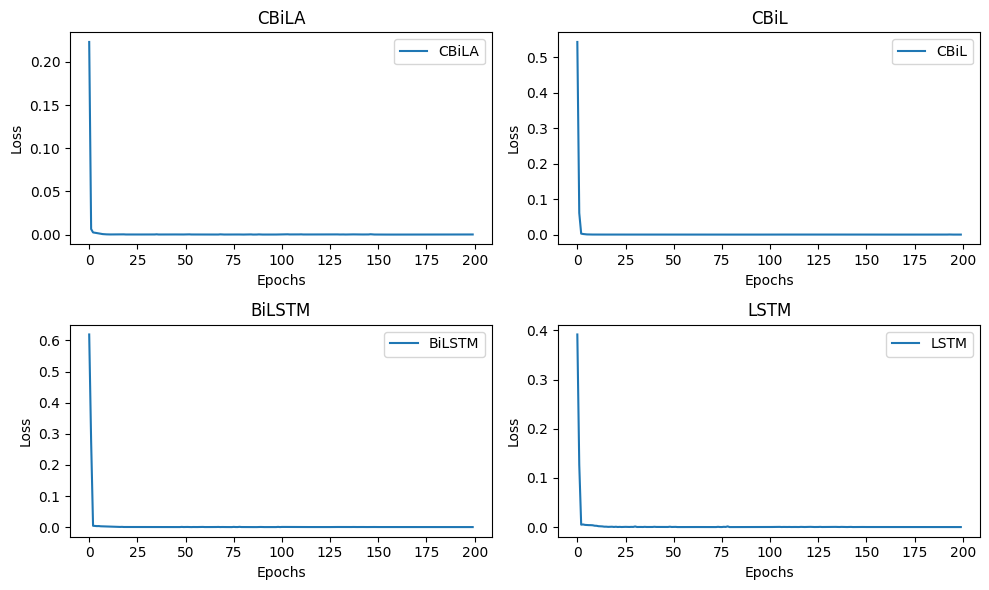

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

plot_idx = 0
for model_name in model_list:
    ax = axes[plot_idx]
    losses = model_losses[model_name].copy()
    # for i in range(epochs, len(losses), epochs):
    #     if i > 0 and i < len(losses)-1:
    #         losses[i] = (losses[i-2] + losses[i+2])/2
    #         losses[i+1] = (losses[i-2] + losses[i+2])/2
    ax.plot(range(len(losses)), losses, label=model_name)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plot_idx += 1

plt.tight_layout()

#### 3.3.2 各模型指标对比直方图

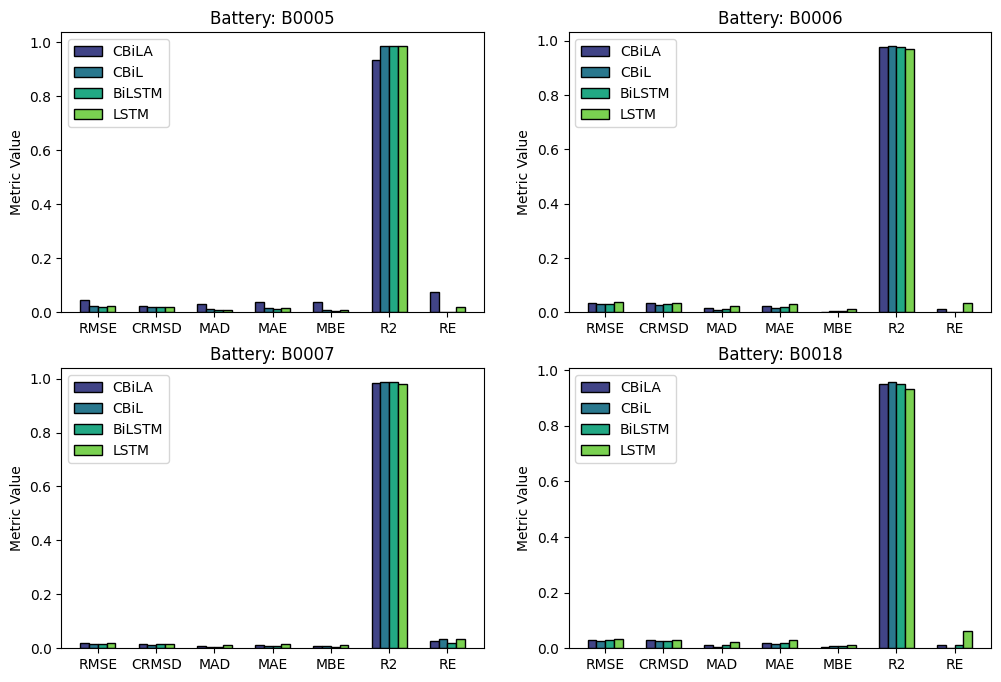

In [21]:
import seaborn as sns

# 绘制直方图
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

colors = sns.color_palette("viridis", n_colors=len(model_list))

for i, battery_name in enumerate(Battery_list):
    ax = axes[i]
    x = np.arange(len(metrics_list))
    width = 0.15  # 每个柱子的宽度

    for j, model_name in enumerate(model_list):
        try:
            metrics = model_metrics[model_name][battery_name]
            values = [metrics[metric_name] for metric_name in metrics_list]
            ax.bar(x + j * width, values, width, 
                   label=model_name, color=colors[j], edgecolor='black')
        except KeyError:
            print(f"Warning: Metrics not found for model \
                  {model_name} on battery {battery_name}")

    ax.set_xticks(x + width * (len(model_list) - 1) / 2)
    ax.set_xticklabels(metrics_list, ha="center")
    ax.set_ylabel('Metric Value')
    ax.set_title(f"Battery: {battery_name}")
    ax.legend()

plt.show()

### 3.4 模型预测

#### 3.4.1 绘制预测结果

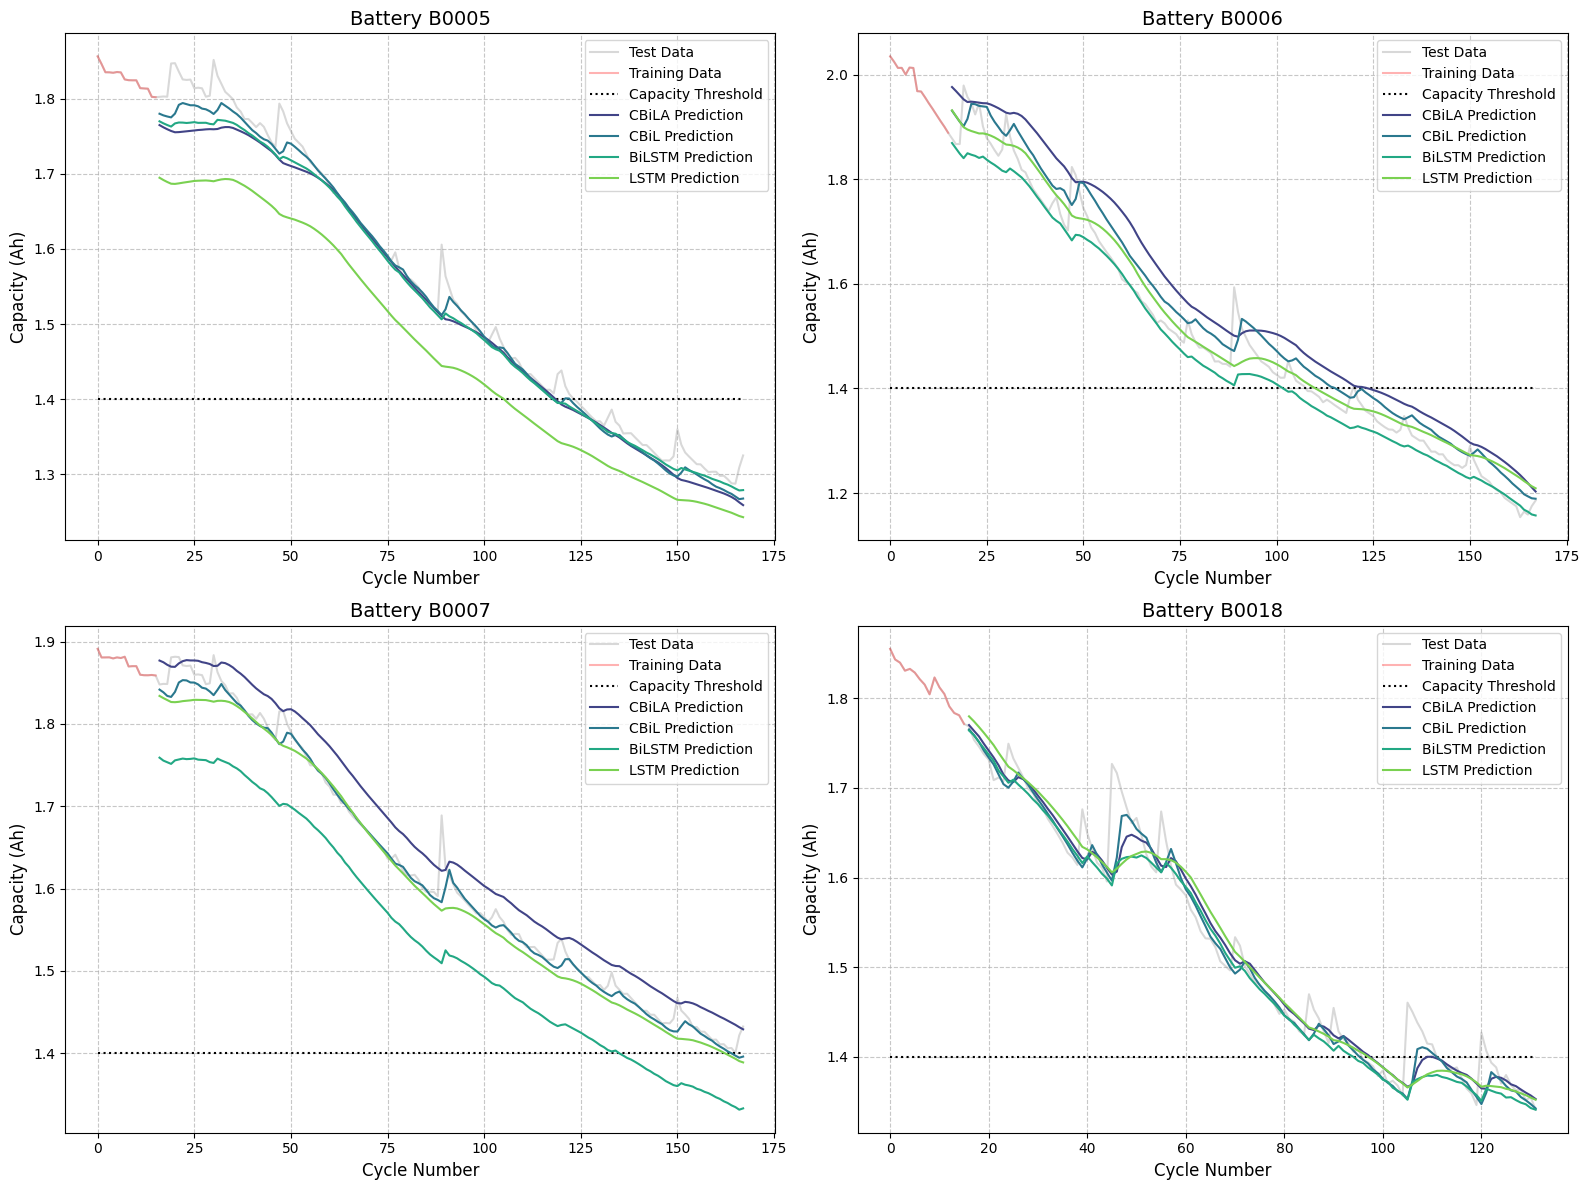

In [22]:
# 为每个电池创建一个子图
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
colors = sns.color_palette("viridis", n_colors=len(model_list))

for i, battery_name in enumerate(Battery_list):
    row = i // 2
    col = i % 2
    
    # 在同一个子图中绘制不同模型的预测结果
    test_data = np.array(capacity[battery_name][1])
    x = np.arange(len(test_data))
    threshold = [Rated_Capacity*0.7] * len(test_data)
    
    # 绘制实际测试数据和固定数据
    ax[row][col].plot(x, test_data, 'gray', alpha=0.3, label='Test Data')
    ax[row][col].plot(x[:window_size], test_data[:window_size], 'r', alpha=0.3, label='Training Data')
    ax[row][col].plot(x, threshold, 'black', ls=':', label='Capacity Threshold')
        
    # 绘制不同模型的预测结果
    for j, model_name in enumerate(model_list):
        try:
            pred_data = model_predictions[model_name][battery_name]
            # 确保pred_data是numpy数组而不是字典
            pred_data = np.array(pred_data)
            ax[row][col].plot(x[window_size:], pred_data, color=colors[j], 
                            label=f'{model_name} Prediction')
        except Exception as e:
            print(f"Warning: Error plotting predictions for model {model_name} on battery {battery_name}: {str(e)}")

    ax[row][col].legend(fontsize=10)
    ax[row][col].set_xlabel('Cycle Number', fontsize=12)
    ax[row][col].set_ylabel('Capacity (Ah)', fontsize=12)
    ax[row][col].set_title(f'Battery {battery_name}', fontsize=14)
    
    # 添加网格线以提高可读性
    ax[row][col].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [23]:
# 1. 保存训练损失数据
loss_df = pd.DataFrame()
for model_name in model_list:
    losses = model_losses[model_name].copy()
    # for i in range(epochs, len(losses), epochs):
    #     if i > 0 and i < len(losses)-1:
    #         losses[i] = (losses[i-2] + losses[i+2])/2
    loss_df[model_name] = pd.Series(losses)
loss_df.to_excel(os.path.join('result', 'Multi_Model_train_loss.xlsx'), 
                 index=True, index_label='Epoch')

# 2. 保存预测结果数据
for model_name in model_list:
    for battery_name in Battery_list:
        pred_df = pd.DataFrame()
        # 获取真实数据
        test_data = np.array(capacity[battery_name][1])
        # 创建预测数据列
        pred_data = np.zeros_like(test_data)
        pred_data[:window_size] = test_data[:window_size]  # 固定数据部分
        pred_data[window_size:] = model_predictions[model_name][battery_name]  # 预测数据部分
        
        # 创建索引
        cycles = np.arange(len(test_data))
        pred_df['Cycle'] = cycles
        pred_df['True_Capacity'] = test_data
        pred_df['Predicted_Capacity'] = pred_data
        
        # 保存到Excel
        pred_df.to_excel(os.path.join('result', f'{model_name}_{battery_name}_predictions.xlsx'), 
                        index=False)

# 3. 保存评估指标数据
for model_name in model_list:
    metrics_df = pd.DataFrame()
    for metric_name in metrics_list:
        metric_values = []
        for battery_name in Battery_list:
            try:
                metric_values.append(model_metrics[model_name][battery_name][metric_name])
            except KeyError:
                metric_values.append(np.nan)
        metrics_df[metric_name] = metric_values
    
    metrics_df.index = Battery_list
    metrics_df.to_excel(os.path.join('result', f'{model_name}_metrics.xlsx'), 
                        index=True, index_label='Battery')